# Overwatch Ult Charge

In [2]:
from __future__ import print_function

import collections
import colorsys
import itertools
import os.path
import pickle
import random
import time

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tqdm

from PIL import ImageFont, ImageDraw, Image 

import keras

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import models
from keras.models import load_model
from skimage import color, data, filters, io, transform

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

MNIST_MODEL_LOC = 'mnist.h5'

Bbox = collections.namedtuple('Bbox', ['x','y','w','h'])

def crop_region(full_image, bbox):
    x, y, w, h = bbox
    return full_image[y:y+h, x:x+w]

dirname = '/Users/ctang/Documents/overwatch_object_detection/overwatch_part1_frames/smaller_dataset'
imgfile = 'frame_05514.png'
valid_pkl = 'validation_dataset.pkl'
valid_straight_pkl = 'valid_straight_dataset.pkl'

image = mpimg.imread(os.path.join(dirname, imgfile))

print('Done loading environment.')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done loading environment.


# Display a random Overwatch frame

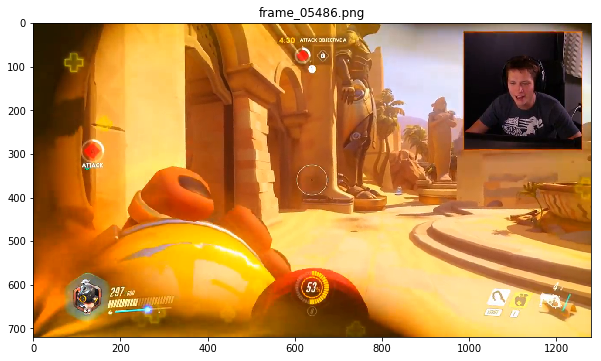

In [3]:
# Uncomment if you want a single image
# random.seed(231)

files = os.listdir(dirname)
imgfile = random.choice(files)
image = mpimg.imread(os.path.join(dirname, imgfile))

plt.imshow(image)
plt.title(imgfile)
plt.show()

# Display region containing Ult Charge

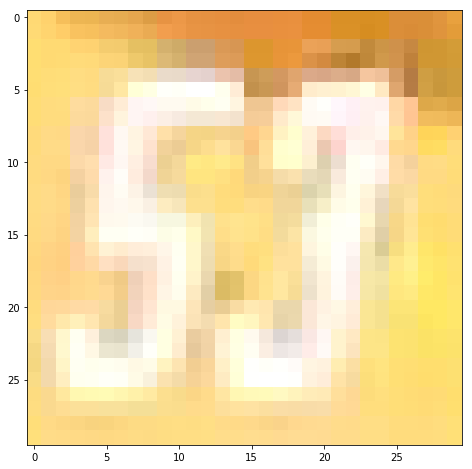

In [4]:
imgfile = 'frame_05514.png'

image = mpimg.imread(os.path.join(dirname, imgfile))
ult_bbox = Bbox(x=625, w=30, y=590, h=30)
plt.imshow(crop_region(image, ult_bbox))
plt.show()

# Train an MNIST model

In [5]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

if os.path.exists(MNIST_MODEL_LOC):
    model = load_model(MNIST_MODEL_LOC)
else:
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    model.save('mnist.h5')
    model.save_weights('mnist.weights.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Test loss: 0.0297505717966
Test accuracy: 0.9897


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

# Exploring MNIST

Show some samples of the MNIST dataset.

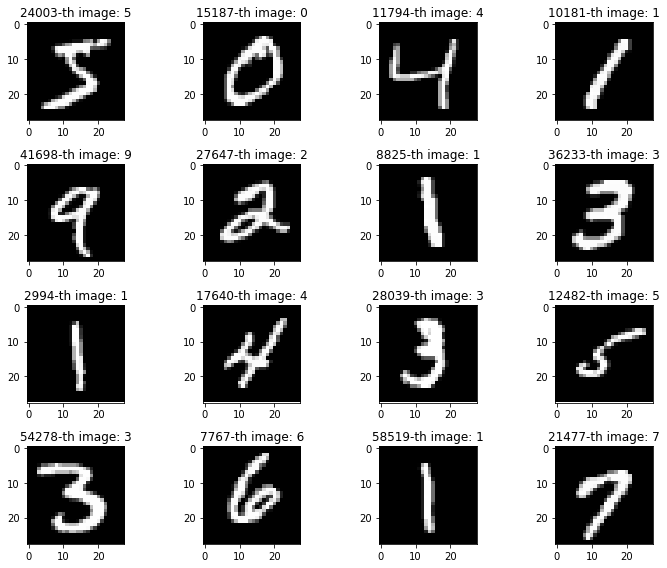

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
for i, region in enumerate(random.sample(range(len(x_train)), 16)):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title("%d-th image: %d" % (region, y_train[i]))
plt.tight_layout()
plt.show()

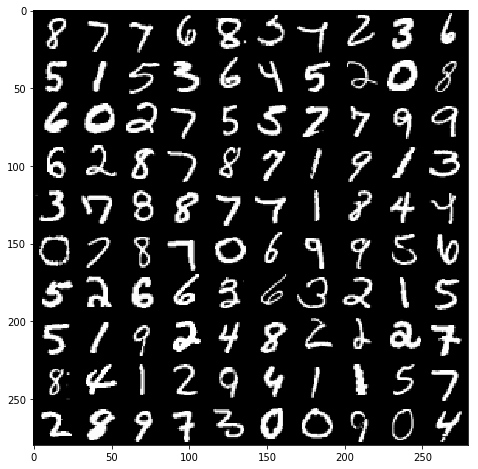

In [9]:
def create_grid(images, n_rows=4, n_cols=4):
    h, w, *other = images[0].shape
    display_grid = np.zeros( (n_rows*h, n_cols*w) )
    for row in range(n_rows):
        for col in range(n_cols):
            row_start = row * h
            row_end = (row + 1) * h
            col_start = col * w
            col_end = (col + 1) * w
            display_grid[row_start:row_end, col_start:col_end] = images[row * n_cols + col]
    return display_grid

def create_rand_grid(images, n_rows=4, n_cols=4):
    h, w, *other = images[0].shape
    n_images = n_rows * n_cols
    display_grid = np.zeros( (n_rows*h, n_cols*w) )
    
    # Sample N images to display
    rand_idx = random.sample(range(len(images)), n_images)

    row_col_pairs = [(row, col) for row in range(n_rows) for col in range(n_cols)]
    
    for idx, (row, col) in zip(rand_idx, row_col_pairs):
        row_start = row * h
        row_end = (row + 1) * h
        col_start = col * w
        col_end = (col + 1) * w
        display_grid[row_start:row_end, col_start:col_end] = images[idx]

    return display_grid

plt.imshow(create_rand_grid(x_train, 10, 10), cmap='gray')

## Show the average image for each digit

/Users/ctang/miniconda3/envs/cs231n/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


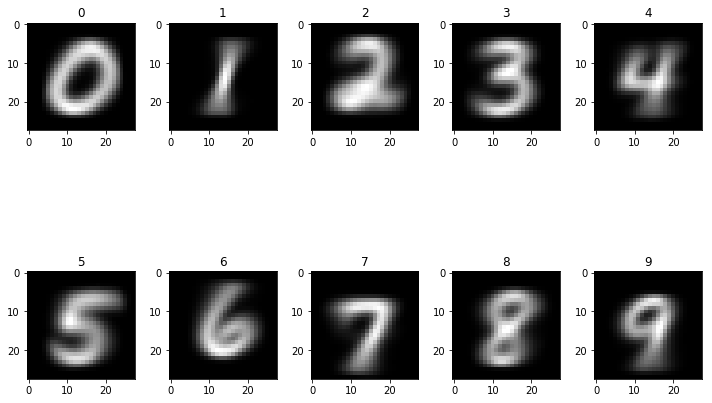

In [10]:
fig = plt.figure()
for i in range(10):
    values = x_train[y_train == i]
    avg = np.mean(values, axis=0).astype(np.uint8)
    plt.subplot(2, 5, i+1)
    plt.imshow(avg, cmap='gray')
    plt.title(i)
fig.tight_layout()
fig.show()

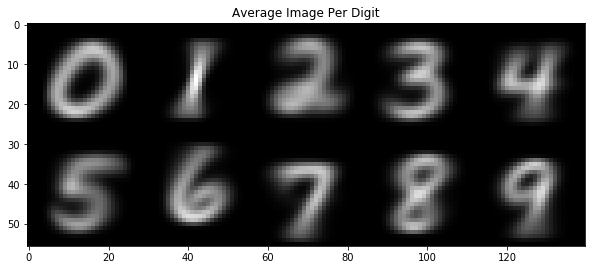

In [11]:
averages = np.array([np.mean(x_train[y_train == i], axis=0).astype(np.uint8) for i in range(10)])
plt.imshow(create_grid(averages, 2, 5), cmap='gray')
plt.title("Average Image Per Digit")
plt.show()

# Exploring Overwatch Dataset

## Display tens and ones digits

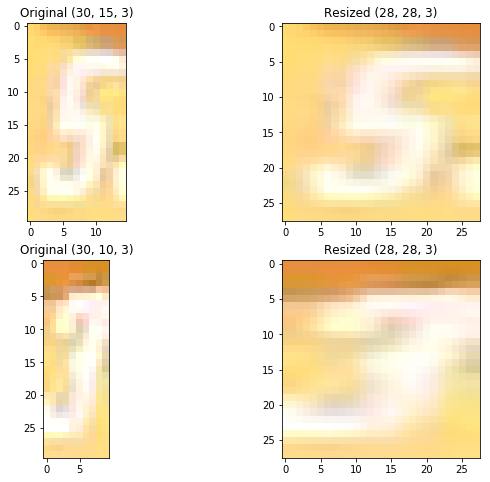

In [12]:
tens = crop_region(image, Bbox(x=625, y=590, w=15, h=30))
plt.subplot(2, 2, 1)
plt.imshow(tens)
plt.title("Original %s" % str(tens.shape))

tens_resized = cv2.resize(tens, (28, 28))
plt.subplot(2, 2, 2)
plt.imshow(tens_resized)
plt.title("Resized %s" % str(tens_resized.shape))

ones = crop_region(image, Bbox(x=640, y=590, w=10, h=30))
plt.subplot(2, 2, 3)
plt.imshow(ones)
plt.title("Original %s" % str(ones.shape))

ones_resized = cv2.resize(ones, (28, 28))
plt.subplot(2, 2, 4)
plt.imshow(ones_resized)
plt.title("Resized %s" % str(ones_resized.shape))

plt.show()

Text(0.5,1,'actual=3, predicted=3')

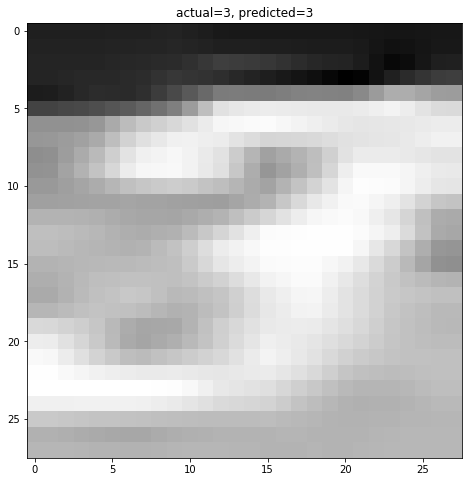

In [13]:
N, H, W, C = 1, 28, 28, 1
region = ones_resized[:,:,1].reshape(N, H, W, C)
result = model.predict(region)
plt.imshow(color.rgb2gray(ones_resized), cmap='gray')
plt.title("actual=%d, predicted=%d" % (3, np.argmax(result)))

# Prepare an evaluation dataset

In [14]:
dirname = '/Users/ctang/Documents/overwatch_object_detection/overwatch_part1_frames/smaller_dataset'

# Ult charge at 53%
start = 5474
end = 5541
fifty_three = [os.path.join(dirname, "frame_0%d.png" % i) for i in range(start, end+1)]

# Ult charge at 54%
start = 5542
end = 5574
fifty_four = [os.path.join(dirname, "frame_0%d.png" % i) for i in range(start, end+1)]
print('Done')

Done


Deserialized validation dataset from Pickle file.
Loaded x_valid: (202, 28, 28, 1)
Loaded y_valid: (202, 10)
Test loss: 1.48412906651
Test accuracy: 0.584158415842


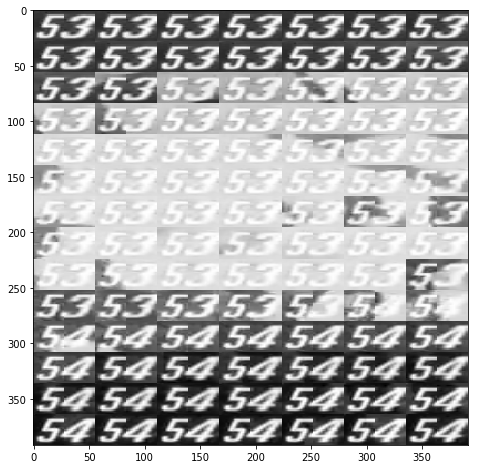

In [15]:
tens_bbox = Bbox(x=625, y=590, w=15, h=30)
ones_bbox = Bbox(x=640, y=590, w=10, h=30)

def load_sheared_dataset():
    """
    Parse out tens and ones digits from each image.
    The digits are sheared.
    """
    if os.path.exists(valid_pkl):
        with open(valid_pkl, 'rb') as f:
            x_valid, y_valid = pickle.load(f)
            print('Deserialized validation dataset from Pickle file.')
    else:
        x_valid = []
        y_valid = []

        for i, imgfile in tqdm.tqdm(enumerate(fifty_three)):
            five = crop_region(mpimg.imread(imgfile), tens_bbox)
            three = crop_region(mpimg.imread(imgfile), ones_bbox)

            x_valid.append(five)
            x_valid.append(three)
            y_valid.append(5)
            y_valid.append(3)

        print('Done producing 5 and 3 images.')

        for i, imgfile in tqdm.tqdm(enumerate(fifty_four)):
            five = crop_region(mpimg.imread(imgfile), tens_bbox)
            four = crop_region(mpimg.imread(imgfile), ones_bbox)

            x_valid.append(five)
            x_valid.append(four)
            y_valid.append(5)
            y_valid.append(4)

        print('Done producing 5 and 4 images.')

        with open(valid_pkl, 'wb') as f:
            pickle.dump((x_valid, y_valid), f)
            print('Done serializing validation dataset.')
    
    return x_valid, y_valid

def preprocess(x):
    """
    Convert the image regions from HxWx4 to 28x28x1
    and grayscale them.
    """
    warped = cv2.resize(x, (28, 28), interpolation=cv2.INTER_LINEAR)
    gray = color.rgb2gray(warped)
    return gray

def visualize(images, N=16):
    sqrts = {
        1: 1,
        2: 4,
        3: 9,
        4: 16,
        5: 25,
        6: 36,
        7: 49,
        8: 64,
        9: 81,
        10: 100
    }
    
    reverse_sqrts = { sqrts[k]:k for k in sqrts }
    

# Load dataset and display samples
x_valid, y_valid = load_sheared_dataset()
# for i, region in enumerate(random.sample(range(len(x_valid)), 16)):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(x_valid[i])
#     plt.title("%d-th image: %d" % (region, y_valid[i]))

# plt.tight_layout()
# plt.show()

x_valid = np.array(list(map(preprocess, x_valid)))
plt.imshow(create_grid(x_valid[:200], 14, 14), cmap='gray')
x_valid = x_valid.reshape(len(x_valid), 28, 28, 1)
y_valid = keras.utils.to_categorical(np.array(y_valid), num_classes)

print("Loaded x_valid:", x_valid.shape)
print("Loaded y_valid:", y_valid.shape)

score = model.evaluate(x_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Print actual and predicted results per image.
# with open('results_slanted.csv', 'w') as f:
#     for i, pair in enumerate(zip(x_val, y_val)):
#         x, y = pair
#         actual = np.argmax(y)
#         predicted = np.argmax(model.predict(x.reshape(1, 28, 28, 1)))
#         f.write("[%d] actual=%d, predicted=%d\n" % (i, actual, predicted))

Show the activations for each convolutional layer. The more black squares, the fewer the activations, the less likely an accurate prediction can be made.

/Users/ctang/miniconda3/envs/cs231n/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Predicted result: 3


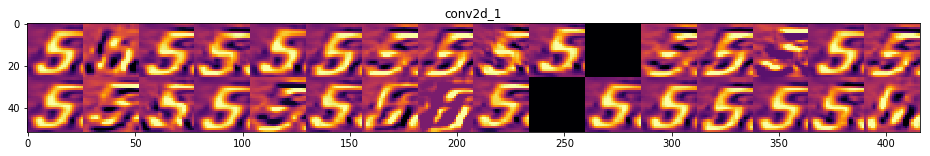

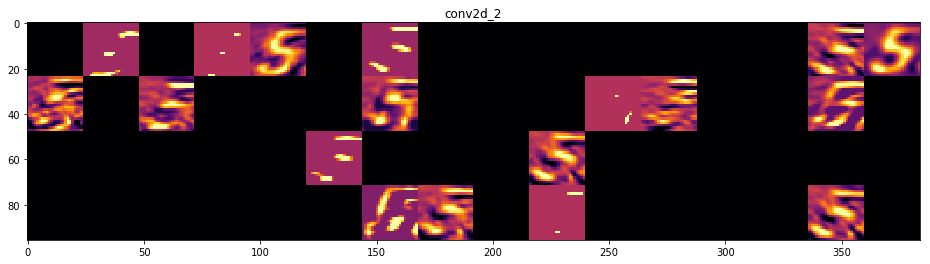

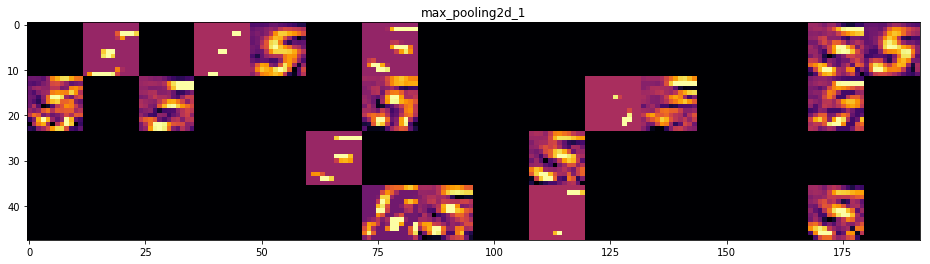

In [17]:
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
img_tensor = np.expand_dims(x_valid[100], axis=0)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[1]

layer_names = [layer.name for layer in model.layers[:3]]
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    _, size, _, n_channels = layer_activation.shape
    n_rows = n_channels // images_per_row
    
    display_grid = np.zeros( (size * n_rows, size * images_per_row) )
    
    for col in range(n_rows):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='inferno')
print("Predicted result:", np.argmax(model.predict(img_tensor)))

# Data Augmentation
## Synthetic Data
Since we're simply classifying the Ult digits in Overwatch, we can generate more of them to create a training set.


pseudocode:

    for every number:
        for 1000 font colors:
            for 1000 canvas colors:
                for -5 to 5 pixel left-right shifts:
                    for -5 to 5 pixel up-down shifts:
                        for 5 types of rotations:
                            generate image

Links:
* [HTML Color Picker](https://htmlcolorcodes.com/)
* [skimage shearing](http://scikit-image.org/docs/0.13.x/api/skimage.transform.html#skimage.transform.AffineTransform)
* [Converting np to PIL image](https://stackoverflow.com/questions/10965417/how-to-convert-numpy-array-to-pil-image-applying-matplotlib-colormap)
* [Drawing custom fonts](http://effbot.org/imagingbook/imagedraw.htm)
* [Drawing custom fonts 2](http://www.codesofinterest.com/2017/07/more-fonts-on-opencv.html)
* [How to shear an image](https://stackoverflow.com/questions/24191545/skewing-or-shearing-an-image-in-python)

Sheared in 0.001930 seconds.
Sheared in 0.000691 seconds.


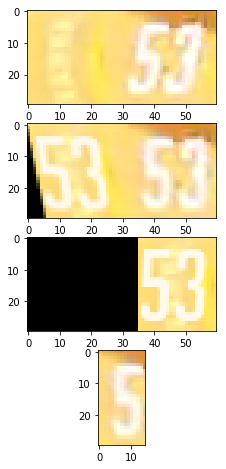

In [19]:
# tens = crop_region(image, Bbox(x=625, y=590, w=30, h=30))
space_tens = crop_region(image, Bbox(x=595, y=590, w=60, h=30))

# color palette
skin_color = (246, 233, 191)
lighter_skin_color = (252,241,202)
even_lighter = (255, 250, 235)

original_region = Image.fromarray(np.uint8(space_tens*255))
sheared_region = Image.fromarray(np.uint8(space_tens*255))
orig_sheared = Image.fromarray(np.uint8(space_tens*255))

draw = ImageDraw.Draw(sheared_region)
font = ImageFont.truetype("data/big_noodle_titling_oblique.ttf", 32)
draw.text((0, -2), "53", font=font, fill=even_lighter)

draw2 = ImageDraw.Draw(orig_sheared)
font2 = ImageFont.truetype("data/big_noodle_titling_oblique.ttf", 32)
draw2.text((0, -2), "53", font=font, fill=even_lighter)

affine_tf = transform.AffineTransform(shear=0.2, translation=(0, 0))

start = time.time()
sheared_region = transform.warp(sheared_region, inverse_map=affine_tf)
end = time.time()

print("Sheared in %f seconds." % (end - start))

translation_only = transform.AffineTransform(translation=(-35, 0))

start = time.time()
orig_sheared = transform.warp(orig_sheared, inverse_map=translation_only)
end = time.time()

print("Sheared in %f seconds." % (end - start))

nrows = 4
ncols = 1

plt.subplot(nrows, ncols, 1)
plt.imshow(original_region)
plt.subplot(nrows, ncols, 2)
plt.imshow(sheared_region)
plt.subplot(nrows, ncols, 3)
plt.imshow(orig_sheared)
plt.subplot(nrows, ncols, 4)

h, w, c = sheared_region.shape
sheared_region = crop_region(sheared_region, Bbox(x=w//2+2, y=0, w=w//4, h=h))
plt.imshow(sheared_region)
plt.show()

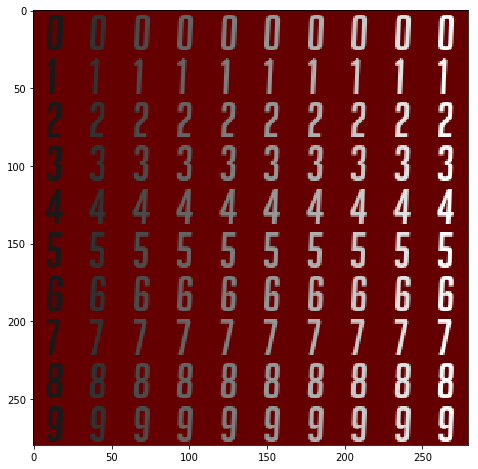

In [35]:
def draw_ult_charge(image):
    canvas_size = (28, 28)
    canvas_color = (0, 0, 0)
    canvas_color = (255, 250, 235)
    upper_lefthand_corner = (8, -3)
    font = ImageFont.truetype(os.path.join(os.getcwd(), "data/big_noodle_titling_oblique.ttf"), 32)
    region = crop_region(image, Bbox(x=200, y=200, w=28, h=28))
    plt.imshow(region)
    pil_region = Image.fromarray(np.uint8(region*255))
    canvas = ImageDraw.Draw(pil_region)
    canvas.text(upper_lefthand_corner, "9", font=font, fill=canvas_color)
    plt.imshow(pil_region)

def gen_synthetic_train_data():
    h, w = 28, 28
    canvas_size = (h, w)
    canvas_color = (100, 0, 0)
    n_rows = 10
    n_cols = 10
    font = ImageFont.truetype(os.path.join(os.getcwd(), "data/big_noodle_titling_oblique.ttf"), 32)
    upper_lefthand_corner = (8, -3)
    
    row_col_pairs = [ (row, col) for row in range(n_rows) for col in range(n_cols) ]
    
    region_list = []
    display_grid = np.zeros( (n_rows*h, n_cols*w, 3) ).astype(np.uint8)

    for number in range(10):
        for color in zip(range(25, 255, 25), range(25, 255, 25), range(25, 255, 25)):
            r,g,b = color
            pil_region = PIL.Image.new("RGB", canvas_size, canvas_color)
            canvas = ImageDraw.Draw(pil_region)
            canvas.text(upper_lefthand_corner, str(number), font=font, fill=(r,g,b))
            region = np.array(pil_region)
            region_list.append(region)

    
    for idx, (row, col) in enumerate([(row, col) for row in range(n_rows) for col in range(n_cols)]):
        display_grid[row*h:row*h+h, col*w:col*w+w, :] = region_list[idx]

    return region_list, display_grid

# draw_ult_charge(image)
region_list, display_grid = gen_synthetic_train_data()
plt.imshow(display_grid)

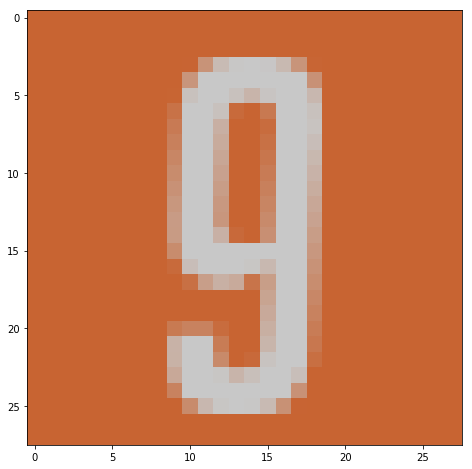

In [34]:
canvas_size = (28, 28)
canvas_color = (200, 100, 50)
text_color = (200, 200, 200)
upper_lefthand_corner = (8, -3)
font = ImageFont.truetype(os.path.join(os.getcwd(), "data/big_noodle_titling_oblique.ttf"), 32)
    
pil_region = PIL.Image.new("RGB", canvas_size, canvas_color)
canvas = ImageDraw.Draw(pil_region)
canvas.text(upper_lefthand_corner, "9", font=font, fill=text_color)
plt.imshow(pil_region)

# Further Exploration
* Generate synthetic data
    * shear digits so that they're straight and not italic 
* Fine-tune on synthetic data
* Run eval on real data

actual=5, predicted=3


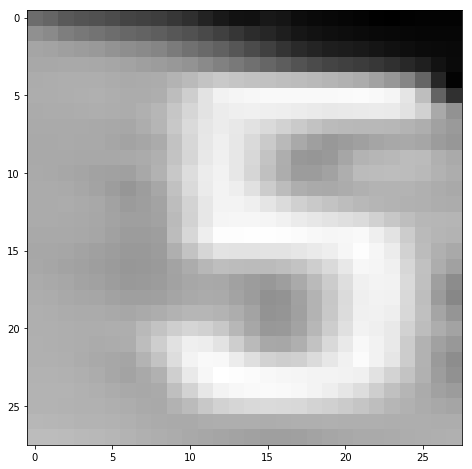

In [23]:
warped = cv2.resize(sheared_region, (28, 28), interpolation=cv2.INTER_LINEAR)
gray = color.rgb2gray(warped)
plt.imshow(gray, cmap='gray')
N, H, W, C = 1, 28, 28, 1
gray = gray.reshape(N, H, W, C)
result = model.predict(gray)
print("actual=%d, predicted=%d" % (5, np.argmax(result)))

Deserialized validation dataset from Pickle file.
Test loss: 1.7640421544
Test accuracy: 0.589108910891


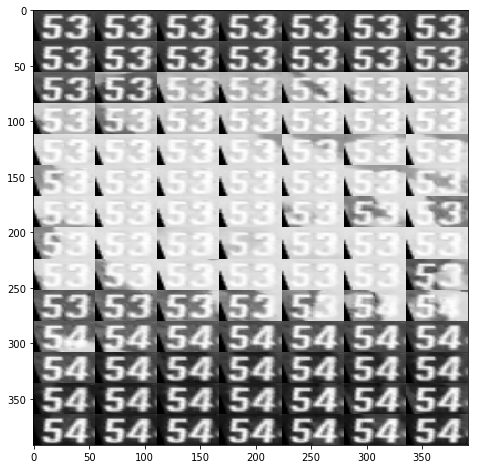

In [22]:
def load_straight_dataset():
    """
    Parse out tens and ones digits from each image,
    and straighten each digit
    """
    tens_bbox = Bbox(x=2, y=0, w=15, h=30)
    ones_bbox = Bbox(x=17, y=0, w=15, h=30)
    ult_charge_bbox = Bbox(x=625, y=590, w=30, h=30)
    shear = transform.AffineTransform(shear=0.2)
    warped_size = (28, 28)

    if os.path.exists(valid_straight_pkl):
        with open(valid_straight_pkl, 'rb') as f:
            x_valid, y_valid = pickle.load(f)
            print('Deserialized validation dataset from Pickle file.')
    else:
        x_valid = []
        y_valid = []

        for imgfile in fifty_three:
            img = mpimg.imread(imgfile)
            region = crop_region(img, ult_charge_bbox)
            region = transform.warp(region, inverse_map=shear)
            five = cv2.resize(crop_region(region, tens_bbox), warped_size, interpolation=cv2.INTER_LINEAR)
            three = cv2.resize(crop_region(region, ones_bbox), warped_size, interpolation=cv2.INTER_LINEAR)
            five = color.rgb2gray(five)
            three = color.rgb2gray(three)
            x_valid.append(five)
            y_valid.append(5)
            x_valid.append(three)
            y_valid.append(3)

        print('Done producing 5 and 3 images.')

        for imgfile in fifty_four:
            img = mpimg.imread(imgfile)
            region = crop_region(img, ult_charge_bbox)
            region = transform.warp(region, inverse_map=shear)
            five = cv2.resize(crop_region(region, tens_bbox), warped_size, interpolation=cv2.INTER_LINEAR)
            four = cv2.resize(crop_region(region, ones_bbox), warped_size, interpolation=cv2.INTER_LINEAR)
            five = color.rgb2gray(five)
            four = color.rgb2gray(four)
            x_valid.append(five)
            y_valid.append(5)
            x_valid.append(four)
            y_valid.append(4)

        print('Done producing 5 and 4 images.')

        with open(valid_straight_pkl, 'wb') as f:
            pickle.dump((x_valid, y_valid), f)
            print('Done serializing validation dataset.')
    
    x_valid = np.array(x_valid)
    y_valid = np.array(y_valid)
    plt.imshow(create_grid(x_valid[:200], 14, 14), cmap='gray')
    x_valid = x_valid.reshape(len(x_valid), 28, 28, 1)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    return x_valid, y_valid


x_valid, y_valid = load_straight_dataset()
score = model.evaluate(x_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [75]:
with open('results_sheared.csv', 'w') as f:
    for i, pair in enumerate(zip(x_valid, y_valid)):
        x, y = pair
        actual = np.argmax(y)
        predicted = np.argmax(model.predict(x.reshape(1, 28, 28, 1)))
        f.write("[%d] actual=%d, predicted=%d\n" % (i, actual, predicted))
print('Done')

Done
